# Detecting pneumonia using chest x-rays

### To Do List

#### Research:
* CNNs
    * How do they work?
    * Idea of transfer learning
* Unique CNN implementations: AlexNet, CapsNet, GNN
    * What is unique about each of these implementations?
    
#### Implementation:
* Basic CNNs (PyTorch, tensorflow, keras)
* Transfer learning example
* Unique CNN implementations
* Understanding what the CNN found important (https://github.com/albermax/innvestigate)

#### Blog:
* Choosing a service (Medium, ...)

## Research

### Convolutional Neural Networks (CNNs)

CNNs are used for classifaction and computer vision. They are made up of three types of layers: convolutional, pooling, and fully-connected (FC). The first layer is a convolutional layer, and the last layer is the only fully-connected layer. The layers in between may be a mix of convolutional and pooling layers [1]. 

##### Convolutional Layers [1]
Convolutiuonal layers have an input, a filter (AKA kernel or feature detector), and a feature map. The feature detector is typically a 2D array of weights, which is applied to a subsection of the input. The dot product between this subsection and the kernel is then calculated. The filter then shifts by a stride, and performs the dot product operation once more, repeating this process until it has covered the entire input. The resulting array of outputs is called the feature map.

Some hyperparameters that can be adjusted in the convolutional layer are number of filters, stride, and zero padding. Number of filters affects the depth of the feature map (e.g. three filters results in a depth three feature map). Stride is the number of pixels the kernel moves after each dot product calculation. Zero padding refers to the amount of padding added to an input (eg. an image) to ensure that the filter fits the image.

After each convolution, the CNN applies a ReLU to introduce nonlinearities into the network, ensuring that the model is a universal approximator.

##### Pooling Layers [1]
Similar to a convolutional layer, except the filter does not use weights. Instead it implements a specific type of pooling: max pooling or average pooling. Max pooling is when the filter selects the pixel of maximum value to send to the output array. Average pooling is when the filter calculates the average value in the receptive field (the values that the filter can see).

More information is lost in pooling layers, but they "reduce complexity, improve efficiency, and limit risk of overfitting".

##### Fully-Connected Layer [1]
Usually uses a softmax activation function to make the final classification prediction.

### Residual Neural Networks (RNNs) [5]

RNNs are neural networks that include residual blocks. In residual blocks, layers feed directly into layers 2-3 layers deeper, while also still feeding into the next layer. These connections to deeper layers are called skip connections or residual connections. 

Generally the layers a NN solve for the true distribution H(x). However, the layers of a residual block solve for the residual! R(x) = Output - Input = H(x) - x => H(x) = R(x) + x. RNNs can also help with the problem of vanishing gradient by using skip connections to back propoagate larger gradients to earlier layers.

### Transfer Learning

Briefly introduced in class was the idea of transfer learning, whereby a previously trained neural network is used in a new problem. The ResNet50 network from PyTorch is a pretrained, RNN with 50 layers. ResNet50 is trained on images, and as such, early layers "learned" basic image features such as lines and shapes that can be used in any image classification problem. This saves an enormous amount of time and compute power, since those layers no longer need to be trained for new problems.

# Basic CNN Implementation

In [4]:
# Need to run with Python 3.6, Tensorflow 1.15, and Keras 2.2.4 for iNNvestigate

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2 # https://pypi.org/project/opencv-python/
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD
import os

import tensorflow
import keras

print(tensorflow.__version__)
print(keras.__version__)

1.15.0
2.2.4


In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            if img == '.DS_Store' :
                continue
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
                
            except Exception as e:
                print(e)
                print (os.path.join(path, img))
                
    return np.array(data)

In [3]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')

C:\Users\willi_jnl\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


#### EDA (Exploratory Data Analysis) [2]

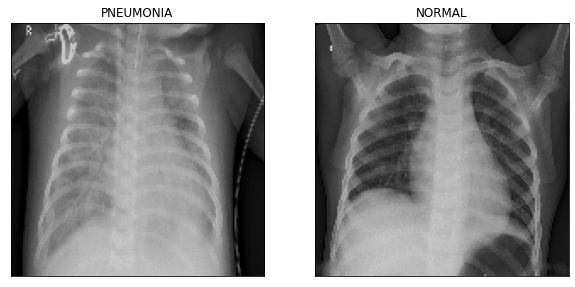

In [7]:
fig = plt.figure(figsize=(10,5))
a1 = fig.add_subplot(1,2,1)
plt.imshow(train[0][0], cmap='gray')
a1.set_title(labels[train[0][1]])
a1.set_xticks([])
a1.set_yticks([])

a2 = fig.add_subplot(1, 2, 2)
plt.imshow(train[-1][0], cmap='gray')
a2.set_title(labels[train[-1][1]])
a2.set_xticks([])
a2.set_yticks([])

plt.show()

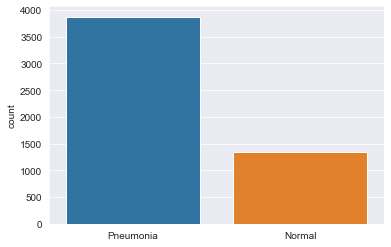

In [8]:
l = []
for i in train:
    if(i[1] == 0):
        l.append('Pneumonia')
    else:
        l.append('Normal')
        
sns.set_style('darkgrid')
sns.countplot(x=l)

plt.show()

#### Basic CNN Implementation [2]

In [17]:
# Preprocessing

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [18]:
# Normalization

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [19]:
# Resizing Data For CNN

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [20]:
# Data Augmentation (Grayscales, Horizontal Flips, Vertical Flips, Random Crops, Color Jitters, Translations, Rotations, ...)
# Slightly alter the training data to increase the number of training examples and prevent overfitting

datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=30,
                             zoom_range=0.2,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False)

datagen.fit(x_train)

In [21]:
# https://faroit.com/keras-docs/2.1.2/models/about-keras-models/

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_13 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 38, 38, 64)        0         
__________

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [23]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), epochs=10, steps_per_epoch = len(x_train) / 32,
                   validation_data=[x_val, y_val], callbacks=[learning_rate_reduction], shuffle=True)

# model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=10, 
#           validation_data=datagen.flow(x_val, y_val), callbacks=[learning_rate_reduction], shuffle=True)

model.save('./models/keras-cnn.h5')

Epoch 1/10
163/163 [==============================] - 265s 2s/step - loss: 0.2989 - acc: 0.8654 - val_loss: 1.4389 - val_acc: 0.5000
Epoch 2/10
163/163 [==============================] - 264s 2s/step - loss: 0.2144 - acc: 0.9155 - val_loss: 1.9138 - val_acc: 0.5000
Epoch 3/10
163/163 [==============================] - 263s 2s/step - loss: 0.1819 - acc: 0.9248 - val_loss: 4.8088 - val_acc: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
163/163 [==============================] - 262s 2s/step - loss: 0.1726 - acc: 0.9354 - val_loss: 1.5980 - val_acc: 0.5000
Epoch 5/10
163/163 [==============================] - 262s 2s/step - loss: 0.1511 - acc: 0.9398 - val_loss: 1.1677 - val_acc: 0.5625
Epoch 6/10
163/163 [==============================] - 342s 2s/step - loss: 0.1490 - acc: 0.9421 - val_loss: 1.2488 - val_acc: 0.5625
Epoch 7/10
163/163 [==============================] - 353s 2s/step - loss: 0.1452 - acc: 0.9467 - val_loss: 0.6020 - val_

In [24]:
model = load_model('./models/keras-cnn.h5')

In [25]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 16s 26ms/step
Accuracy of the model is -  91.18589743589743 %


# iNNvestigate [7]

In [100]:
import innvestigate
import innvestigate.applications.imagenet
import innvestigate.layers as ilayers
import innvestigate.utils as iutils
import innvestigate.utils.keras as kutils
import innvestigate.utils.keras.checks as kchecks
import innvestigate.utils.keras.graph as kgraph

innvestigate.__version__

'1.0.9'

In [71]:
if keras.backend.image_data_format == 'channels_first':
    input_shape = (1, 150, 150)
else:
    input_shape = (150, 150, 1)

In [72]:
model = load_model('./models/keras-cnn.h5')

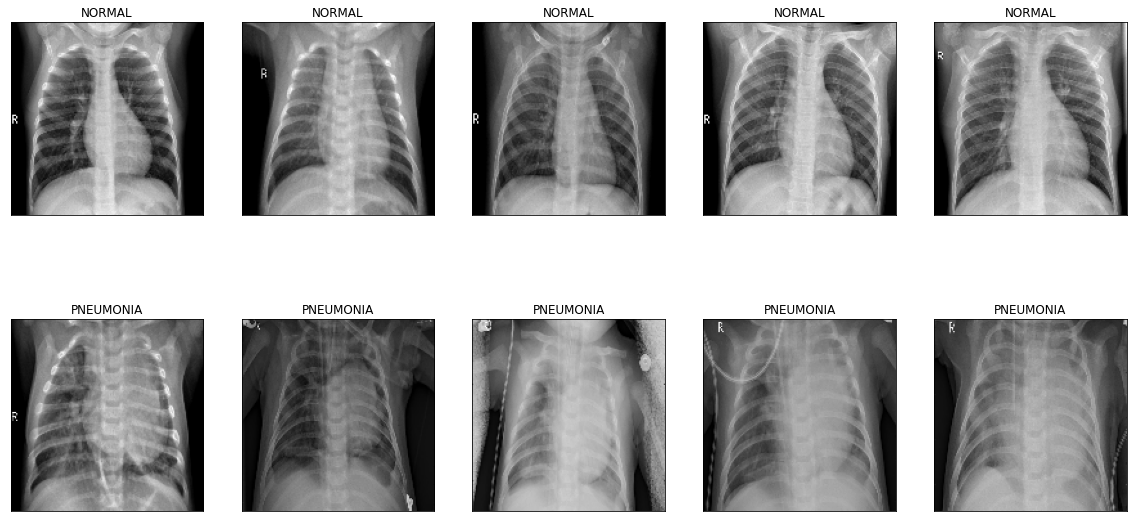

In [130]:
images = [x_test[i] for i in range(-5, 5)]
labels = ['NORMAL' if y_test[i] else 'PNEUMONIA' for i in range(-5, 5)]

fig, axs = plt.subplots(2, 5, figsize=(20,10))

for ax, im, l in zip(np.append(axs[0], axs[1]), images, labels):
    ax.imshow(im, cmap='gray')
    ax.set_title(l)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()    

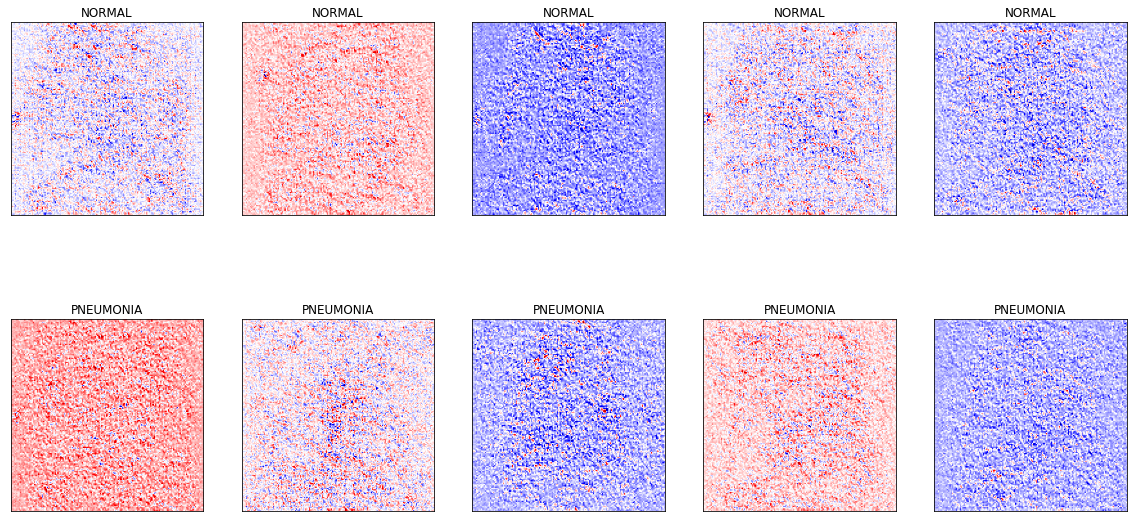

In [131]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer('gradient', model)

fig, axs = plt.subplots(2, 5, figsize=(20,10))

for ax, im, l in zip(np.append(axs[0], axs[1]), images, labels):
    
    # Applying the analyzer
    analysis = gradient_analyzer.analyze(im.reshape(1, 150, 150, 1))
    
    ax.imshow(analysis.squeeze(), cmap='seismic')
    ax.set_title(l)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show() 

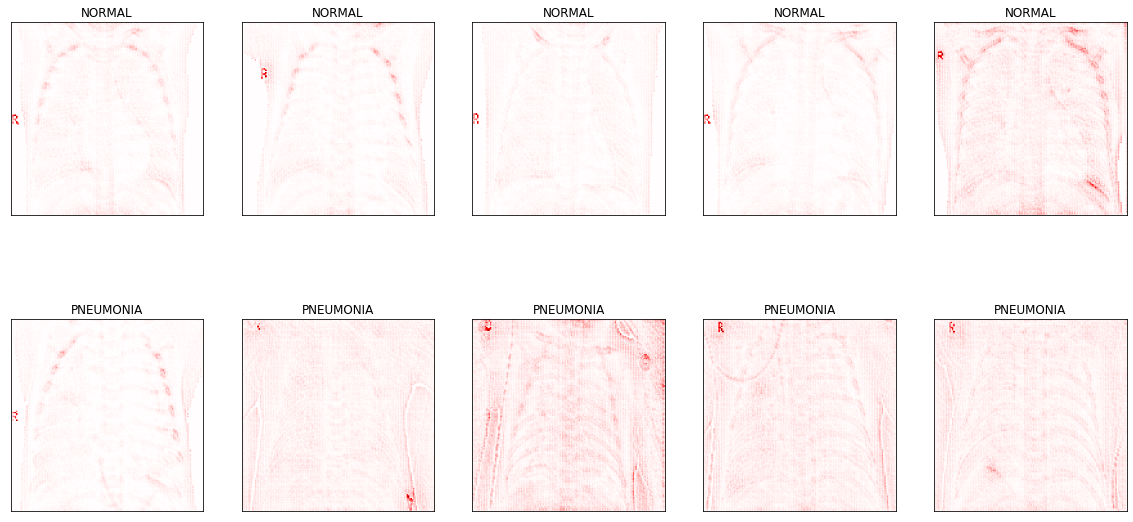

In [132]:
# Creating an analyzer
dt_analyzer = innvestigate.create_analyzer('deep_taylor', model)

fig, axs = plt.subplots(2, 5, figsize=(20,10))

for ax, im, l in zip(np.append(axs[0], axs[1]), images, labels):
    
    # Applying the analyzer
    a = dt_analyzer.analyze(im.reshape(1, 150, 150, 1))

    # Displaying the gradient
    a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
    a /= np.max(np.abs(a))
    # Plot
    ax.imshow(a, cmap="seismic", clim=(-1, 1))
    ax.set_title(l)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Transfer Learning with ResNet [4]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#### EDA [4]

In [ ]:
dataset = ImageFolder('./chest_xray/train',
                         transform=tt.Compose([tt.Resize(255),
                                               tt.CenterCrop(224),
                                               tt.RandomHorizontalFlip(),
                                               tt.RandomRotation(10),
                                               tt.RandomGrayscale(),
                                               tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                               tt.ToTensor()
                                              ]))

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
train_size = round(len(dataset)*0.7)
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [ ]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[0:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

#### Data Preprocessing [4]

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

In [ ]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds)), preds

#### Creating Model [4]

In [ ]:
class PneumoniaModelBase(nn.Module):
    
    def training_step(self, batch, weight):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels, weight=weight)
        acc, preds = accuracy(out, labels)
        
        return {'train_loss': loss, 'train_acc': acc}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc,preds = accuracy(out, labels)
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
        
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}   

In [ ]:
resnet50 = models.resnet50(pretrained=True)

In [ ]:
class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        for param in self.network.fc.parameters():
            param.require_grad = False
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, 2)
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, lr, model, train_loader, val_loader, weight, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = {}
    
    optimizer = opt_func(model.parameters(), lr)
    best_loss = 1
    for epoch in range(epochs):
        
        model.train()
        train_outputs = []
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']
            train_outputs.append(outputs)
            
            train_results = model.train_epoch_end(train_outputs)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
        val_results = evaluate(model, val_loader)
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            
        model.epoch_end(epoch, train_results, val_results)
        
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
                
        model.load_state_dict(best_model_wts)
        
        return history, optimizer, best_loss

#### Training Model [4]

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(PneumoniaResnet(), device)

In [ ]:
epochs = 20
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
weight = torch.FloatTensor([3876/1342+3876, 1342/(1342+3876)]).to(device)

In [ ]:
# Had to run this on Kaggle since my GPU did not have enough memory

# history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight,
#                                     grad_clip=grad_clip,
#                                     weight_decay=weight_decay,
#                                     opt_func=opt_func)

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('./models/PneumoniaResnet.pth')

#### Evalutaion [4]

In [ ]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [ ]:
test_dataset = ImageFolder('./chest_xray/test', 
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),                                                              
                                                 tt.ToTensor()
                                                ]))

In [ ]:
test_dl = DataLoader(test_dataset, batch_size=256)
# test_dl = DeviceDataLoader(test_dl, device)
preds,labels = test_predict(model, test_dl)

In [ ]:
cm = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.show()

# Experimenting with FastAI [6]

In [10]:
from fastai.vision.all import *
from fastai.data.all import *
import numpy as np

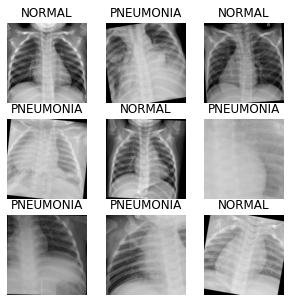

In [11]:
path = './chest_xray/train'
fnames = get_image_files(path)

def label_func(x): return x.parent.name

dls = ImageDataLoaders.from_path_func(path, fnames, label_func, item_tfms=Resize(224), bs=16, num_workers=0,
                                      batch_tfms=aug_transforms(pad_mode='zeros', max_warp=0, max_zoom=1)) 
dls.show_batch(max_n=9, figsize=(5,5))

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=True)

learn.fit_one_cycle(1)

## References

[1] https://www.ibm.com/cloud/learn/convolutional-neural-networks

[2] https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy

[3] https://data.mendeley.com/datasets/rscbjbr9sj/2 (THIS IS THE DATASET)

[4] https://www.kaggle.com/teyang/pneumonia-detection-resnets-pytorch

[5] https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

[6] https://course19.fast.ai/videos/?lesson=1

[7] Alber, M., Lapuschkin, S., Seegerer, P., Hägele, M., Schütt, K. T., Montavon, G., Samek, W., Müller, K. R., Dähne, S., & Kindermans, P. J. (2019). iNNvestigate neural networks! Journal of Machine Learning Research, 20.